In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate, integrate, optimize, stats
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

import pycbc.conversions as conv

from gwbench import injections
from gwbench import network
from gwbench import snr

In [315]:
plotdir = 'power_law_hyper_param_plots/'

alpha_inj = -3.5
mmin_inj = 5.0
mmax_inj = 100.

import matplotlib
font = {'family' : 'serif',
        'size'   : 12}

matplotlib.rc('font', **font)

# Read simulation

In [316]:
# File with Mc biases

# files = [f'powerlaw_3.5_lams/powerlaw_alpha_3.5_lam_0_1_Mc_0_1296.csv']
# files = ['fpowerlaw_1.0_lams/powerlaw_alpha_1.0_lam_0_1_Mc_0_test.csv']
files = [f'powerlaw_{np.abs(alpha_inj):.1f}_lams/powerlaw_alpha_{np.abs(alpha_inj):.1f}_lam_0_1_Mc_0_test.csv']


df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_mc_raw = df1.loc[~(df1==0).all(axis=1)]
df_mc_raw = df_mc_raw[df_mc_raw["Mc"] > 0]
# df_mc_raw = df_mc_raw[df_mc_raw["m1"] < 20]
# df_mc_raw = df_mc_raw[df_mc_raw["z"] < 2]
print("Total number of events:",len(df_mc_raw))


Total number of events: 1296


In [317]:
# File with eta biases

# files = [f'powerlaw_3.5_lams/powerlaw_alpha_3.5_lam_0_1_eta_0_1296.csv']
# files = [f'powerlaw_1.0_lams/powerlaw_alpha_1.0_lam_0_1_eta_0_test.csv']
files = [f'powerlaw_{np.abs(alpha_inj):.1f}_lams/powerlaw_alpha_{np.abs(alpha_inj):.1f}_lam_0_1_eta_0_test.csv']

df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_eta_raw = df1.loc[~(df1==0).all(axis=1)]
df_eta_raw = df_eta_raw[df_eta_raw["Mc"] > 0]
# df_eta_raw = df_eta_raw[df_eta_raw["m1"] < 20]
# df_eta_raw = df_eta_raw[df_eta_raw["z"] < 2]
print("Total number of events:",len(df_eta_raw))

Total number of events: 1296


## Sample from the events if needed

In [318]:
# # Select random subset of the data
# n_samples = 1200
# sample_indices = np.random.randint(0, len(df_mc_raw), n_samples)
# df_mc = df_mc_raw.iloc[sample_indices]
# df_eta = df_eta_raw.iloc[sample_indices]

# select all data
df_mc = df_mc_raw
df_eta = df_eta_raw

$$ p(\alpha) = e^{-N_s} \Gamma_{i=1}^{N_t} N_s \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1) $$

The products are over all events. 

Or, in log likelihood space, 
$$ log(p(\alpha)) = log(e^{-N_s}) + log(\Gamma_{i=1}^{N_t} N_s \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1) )$$

which simplifies to 

$$ log(p(\alpha)) = -N_s + \Sigma_{i=1}^{N_t} log(N_s * \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1)) $$

#  Define the functions

In [319]:
def p_m1(m1, alpha, m_min, m_max):
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1:
        N1 = 1 / ((m_max**(alpha+1) - m_min**(alpha+1))/(alpha+1))
    else:
        N1 = 1/(np.log(m_max/m_min))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, 0])


def normal_dist(m1, mu, sigma, amp=1.0):
    A = np.sqrt(2*np.pi) * sigma
    return amp * np.exp(-(m1 - mu) ** 2 / (2 * sigma**2)) / A

def trunc_normal_dist(m1, mu, sigma, m_min=None, m_max=None):
    if m_min is None:
        m_min = np.min(m1)
    if m_max is None:
        m_max = np.max(m1)
        
    a, b = (m_min - mu) / sigma, (m_max - mu) / sigma
    return stats.truncnorm.pdf(m1, a, b, loc = mu, scale = sigma)

def sigmoid(x, a):
    return 1/(1 + np.exp(a-x))

In [320]:
m1_min=5
m1_max=100
alpha=-3.5


m1 = np.linspace(m1_min, m1_max, 300000)
print(integrate.trapezoid(p_m1(m1, alpha, m1_min, m1_max), m1))

1.0000000007123995


In [321]:
m1 = np.linspace(m1_min, m1_max, 300000)
mu = 34
sigma = 1.4
print(integrate.trapezoid(normal_dist(m1, mu, sigma), m1))

1.0


In [322]:
m1 = np.linspace(m1_min, m1_max, 300000)
mu = 134
sigma = 1.4
print(integrate.trapezoid(trunc_normal_dist(m1, mu, sigma), m1))

1.0000025188661694


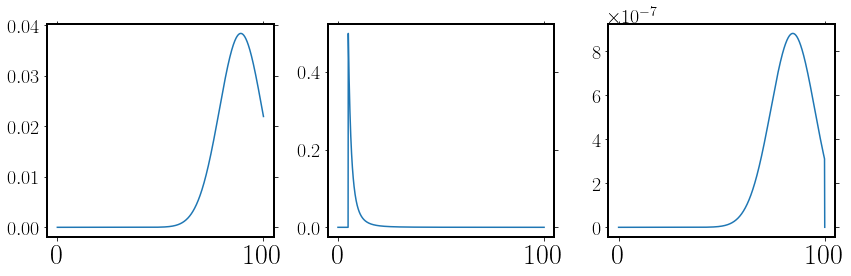

In [324]:
# Visualize the defined functions for sanity

m1_min=5
m1_max=100

m1 = np.linspace(0, m1_max, 1000)
mu = 89
sigma = 10.4
alpha=-3.5

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax1.plot(m1, normal_dist(m1, mu, sigma))
ax2.plot(m1, p_m1(m1, alpha, m1_min, m1_max))
# ax2.set_xlim(0, 20)
ax3.plot(m1, (normal_dist(m1, mu, sigma)*p_m1(m1, alpha, m1_min, m1_max)))


plt.tight_layout()
plt.show()


# Compute Hyper posterior

In [325]:
def log_likelihood_alpha(m1_mu_events, m1_sigma_events, \
    alpha_min=-4.5, alpha_max=-3, n_alpha=30, \
        m1_min_int = 5., m1_max_int=500., n_m1_int=10000, \
        m1_min_pow = 5., m1_max_pow=500., \
            Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):
    
    m1_int_range = np.linspace(m1_min_int, m1_max_int, n_m1_int)
    alpha_range = np.linspace(alpha_min, alpha_max, n_alpha)
    log_p_alpha = np.zeros(n_alpha)

    for a in range(n_alpha):
        alpha = alpha_range[a]
        total_int = 0

        for i in range(Nt):
            integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * trunc_normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i], m1_min_int, m1_max_int)
            int_term = integrate.trapezoid(integrand, m1_int_range)
            # if int_term == 0:
            #     int_term=1.0

            total_int = total_int + np.log(Ns) + np.log(int_term)
            
        log_p_alpha[a] = -Ns + total_int
        
    return log_p_alpha, alpha_range

## $\lambda$=0, Source Frame masses

In [326]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
z = df_mc["z"]
mchirp = df_mc["Mc"]/ (1+z)
eta = df_mc["eta"]

sigMc_raw = df_mc["Mc_stat_err"]
sigEta = df_eta["eta_stat_err"]
sigZ = df_mc["z_stat_err"]

sigMc = np.sqrt((((mchirp**2)*((sigZ**2)*((1.+z)**-4.)))+((sigMc_raw**2)*((1.+z)**-2.))))


m1_mu_detections = df_mc["m1"] / (1+z)

aux0=0.25*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
aux1=(((0.3*((1.+(-4.*eta))**0.5))+((0.3*((1.+(-4.*eta))**1.))+(1.*eta)))**2)
aux2=(((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((sigMc_raw**2)*(((1.+z)**2))))
aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+(0.25*aux2)
m1_sigma_events=np.sqrt(((eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))))
m1_sigma_events = m1_sigma_events.values

# sample mu from the detection gaussians to avoid Biases
m1_mu_sampled = np.random.normal(m1_mu_detections, m1_sigma_events)

In [327]:
print(np.sum(m1_mu_sampled<5))
print(np.sum(m1_mu_sampled>100))

109
0


In [328]:
log_p_alpha_lam_0_src, alpha_range_src = log_likelihood_alpha(m1_mu_sampled, m1_sigma_events, \
    alpha_min=alpha_inj-0.5, alpha_max=alpha_inj+0.5, n_alpha=100, \
    m1_min_int = 5., m1_max_int=500., n_m1_int=20000,\
    m1_min_pow = 5., m1_max_pow=100.,\
    Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"]))
log_alpha_norm =log_p_alpha_lam_0_src - np.max(log_p_alpha_lam_0_src)

most likely alpha (IN SOURCE FRAME) = -3.696969696969697


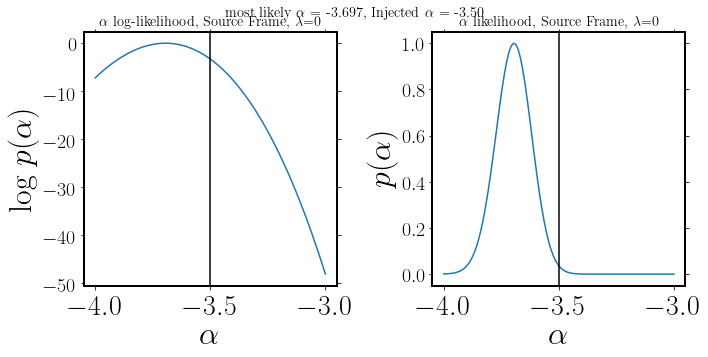

In [329]:
print("most likely alpha (IN SOURCE FRAME) =",alpha_range_src[np.argmax(log_p_alpha_lam_0_src)])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(alpha_range_src, log_alpha_norm)
axes[0].axvline(x=alpha_inj, color='k')
axes[0].set_ylabel("log $p(\\alpha$)")
axes[0].set_xlabel("$\\alpha$")
axes[0].set_title("$\\alpha$ log-likelihood, Source Frame, $\lambda$=0")

axes[1].plot(alpha_range_src, np.exp(log_alpha_norm))
axes[1].axvline(x=alpha_inj, color='k')
axes[1].set_ylabel("$p(\\alpha$)")
axes[1].set_xlabel("$\\alpha$")
axes[1].set_title("$\\alpha$ likelihood, Source Frame, $\lambda$=0")

plt.suptitle(f"most likely $\\alpha$ = {alpha_range_src[np.argmax(log_p_alpha_lam_0_src)]:.3f}, Injected $\\alpha$ = {alpha_inj:.2f}", y=0.99)
plt.tight_layout()

plt.savefig(plotdir+f'alpha_{alpha_inj:.1f}_hyper_posterior.pdf')
plt.show()

In [336]:
target_func = normal_dist
y, X = np.exp(log_alpha_norm), alpha_range_src
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-3.1, 0.6, 1.0])

mu_alpha = popt[0]
sig_alpha = popt[1]
print(popt)

print(rf"Injected $\\alpha$ is {np.abs(alpha_inj - mu_alpha)/sig_alpha :.2f} $\sigma$ away")

[-3.69597036  0.07752741  0.19439614]
Injected $\\alpha$ is 2.53 $\sigma$ away


## Try with fewer events:

In [110]:
log_p_alpha_lam_0_src_100, alpha_range_src = log_likelihood_alpha(m1_mu_sampled, m1_sigma_events, \
    alpha_min=-4.4, alpha_max=-2.7, n_alpha=30, \
    m1_min_pow = 5, m1_max_pow=100., \
    m1_min_int = 5, m1_max_int=200., n_m1_int=10000, Ns=100, Nt=100)
log_p_alpha_lam_0_src_100 = log_p_alpha_lam_0_src_100 - np.max(log_p_alpha_lam_0_src_100)

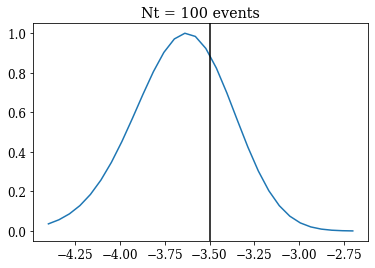

In [111]:
plt.plot(alpha_range_src, np.exp(log_p_alpha_lam_0_src_100))
plt.axvline(x=-3.5, color='k')
plt.title("Nt = 100 events")
plt.show()

In [112]:
target_func = normal_dist
y, X = np.exp(log_p_alpha_lam_0_src_100), alpha_range_src
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-3.1, 0.6, 1.0])

print(popt)

[-3.64315823  0.27424778  0.68756638]


# 2D inference (Manual)

In [113]:
def log_likelihood_alpha_m1min(m1_mu_events, m1_sigma_events, \
    alpha_min=-4.5, alpha_max=-3, n_alpha=10, \
        m1_low_min = 3.0, m1_low_max = 7., n_m1_low=10,\
        m1_max_int=500., n_m1_int=10000, \
        m1_max_pow=500., \
            Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):

    alpha_range = np.linspace(alpha_min, alpha_max, n_alpha)
    m1_low_range = np.linspace(m1_low_min, m1_low_max, n_m1_low)

    log_likelihoods = np.zeros((n_m1_low, n_alpha))

    for m1_low_index in range(n_m1_low):
        m1_min_pow = m1_low_range[m1_low_index]

        m1_int_range = np.linspace(m1_min_pow, m1_max_int, n_m1_int)
        
        for a in range(n_alpha):
            
            alpha = alpha_range[a]
            total_int = 0

            for i in range(Nt):
                integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * trunc_normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i], m1_min_pow, m1_max_int)
                int_term = integrate.trapezoid(integrand, m1_int_range)

                total_int = total_int + np.log(Ns) + np.log(int_term)
                
            log_likelihoods[m1_low_index, a] = -Ns + total_int
        
        
           
    return log_likelihoods, alpha_range, m1_low_range

## Set Data

In [114]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
z = df_mc["z"]
mchirp = df_mc["Mc"]/ (1+z)
eta = df_mc["eta"]

sigMc_raw = df_mc["Mc_stat_err"]
sigEta = df_eta["eta_stat_err"]
sigZ = df_mc["z_stat_err"]

sigMc = np.sqrt((((mchirp**2)*((sigZ**2)*((1.+z)**-4.)))+((sigMc_raw**2)*((1.+z)**-2.))))


m1_mu_detections = df_mc["m1"] / (1+z)

aux0=0.25*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
aux1=(((0.3*((1.+(-4.*eta))**0.5))+((0.3*((1.+(-4.*eta))**1.))+(1.*eta)))**2)
aux2=(((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((sigMc_raw**2)*(((1.+z)**2))))
aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+(0.25*aux2)
m1_sigma_events=np.sqrt(((eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))))
m1_sigma_events = m1_sigma_events.values

# sample mu from the detection gaussians to avoid Biases
m1_mu_sampled = np.random.normal(m1_mu_detections, m1_sigma_events)

## Compute likelihoods

In [117]:
log_likelihoods, alpha_range, m1_low_range = log_likelihood_alpha_m1min(m1_mu_sampled, m1_sigma_events, \
    alpha_min=alpha_inj-3.5, alpha_max=alpha_inj+3.5, n_alpha=30, \
    m1_low_min = 1.0, m1_low_max = 8.0, n_m1_low=30,\
    m1_max_int=500., n_m1_int=10000, \
    m1_max_pow=100.,\
    Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"]))
    
log_likelihoods_norm = log_likelihoods - np.max(log_likelihoods)

In [148]:
index_max = np.argmax(log_likelihoods_norm)
index_max = np.unravel_index(index_max, log_likelihoods_norm.shape)

print("alpha:", alpha_range[index_max[0]])
print("m1_min:", m1_low_range[index_max[1]])

index_max

alpha: 0.0
m1_min: 1.0


(29, 0)

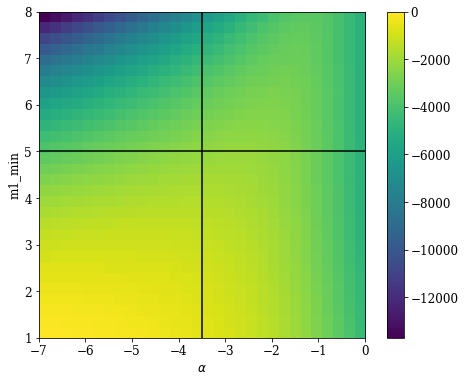

In [120]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.imshow(log_likelihoods_norm, extent =[alpha_range.min(), alpha_range.max(), m1_low_range.min(), m1_low_range.max()])

plt.axvline(x=alpha_inj, color='k')
plt.axhline(y=5.0, color='k')

plt.colorbar()
plt.xlabel("$\\alpha$")
plt.ylabel("m1_min")

plt.savefig(plotdir+'alpha_3.5_m1_min_2d_posterior.pdf')
plt.show()
    


# 2D Inference, MCMC test

https://github.com/kazewong/TutorialsAndExplains/blob/main/HBA_explain/Session_version.ipynb

In [237]:
import emcee
import corner

In [238]:
Ns = len(df_mc)
Nt = Ns

def lnprob(m1_mu, m1_sigma, m1_min_pow, m1_max_pow, alpha):

    m1_int_range = np.linspace(0, 500, 10000)

    total_int = 0

    for i in range(len(m1_mu)):
        integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * trunc_normal_dist(m1_int_range, m1_mu[i], m1_sigma[i])
        int_term = integrate.trapezoid(integrand, m1_int_range)

        total_int = total_int + np.log(int_term)

    return total_int

In [250]:
mmin_low, mmin_hi = [2,10]
mmax_low, mmax_hi = [80,150]
alpha_low, alpha_hi = [-8,-1]



def population_posterior(params, m1_mu, m1_sigma):
    mmin = params[0]
    mmax = params[1]
    alpha = params[2]
    if (mmin>mmin_hi) or (mmin<mmin_low):
        return -np.inf
    if (mmax>mmax_hi) or (mmax<mmax_low):
        return -np.inf
    if (alpha>alpha_hi) or (alpha<alpha_low):
        return -np.inf

    else:
        return lnprob(m1_mu, m1_sigma, mmin, mmax, alpha)

In [243]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
z = df_mc["z"]
mchirp = df_mc["Mc"]/ (1+z)
eta = df_mc["eta"]

sigMc_raw = df_mc["Mc_stat_err"]
sigEta = df_eta["eta_stat_err"]
sigZ = df_mc["z_stat_err"]

sigMc = np.sqrt((((mchirp**2)*((sigZ**2)*((1.+z)**-4.)))+((sigMc_raw**2)*((1.+z)**-2.))))


m1_mu_detections = df_mc["m1"] / (1+z)

aux0=0.25*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
aux1=(((0.3*((1.+(-4.*eta))**0.5))+((0.3*((1.+(-4.*eta))**1.))+(1.*eta)))**2)
aux2=(((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((sigMc_raw**2)*(((1.+z)**2))))
aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+(0.25*aux2)
m1_sigma_events=np.sqrt(((eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))))
m1_sigma_events = m1_sigma_events.values

# sample mu from the detection gaussians to avoid Biases
m1_mu_sampled = np.random.normal(m1_mu_detections, m1_sigma_events)

In [257]:
ndim, nwalkers = 3, 30
ivar = 1. / np.random.rand(ndim)
p0 = np.random.uniform([mmin_low,mmax_low,alpha_low], [mmin_hi,mmax_hi,alpha_hi], size=(nwalkers,ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, population_posterior, args=[m1_mu_sampled, m1_sigma_events])
sampler.run_mcmc(p0, 500)



/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


State([[  5.04862408  93.55881561  -3.70809852]
 [  8.62628493 116.94374998  -7.08642685]
 [  9.89853263 129.57890373  -7.33671778]
 [  5.0502526  130.24599775  -3.76079239]
 [  9.38012877 114.62668958  -7.16192496]
 [  4.99928698 117.10511484  -3.66177444]
 [  8.19296493  84.58484747  -6.8545794 ]
 [  5.04986576 102.42132507  -3.65263819]
 [  7.89356617 124.16982038  -7.23294816]
 [  5.00007993  95.56920067  -3.80546738]
 [  8.28601045  89.93322764  -7.25757836]
 [  8.7311241  122.4936302   -4.32836234]
 [  5.04802277 145.15314412  -3.68612003]
 [  9.38789738 106.59567064  -5.87416955]
 [  5.00022849 129.39000433  -3.74148411]
 [  4.99815544 148.7275556   -3.62335038]
 [  4.99947815  99.7731805   -3.77193934]
 [  5.05027004 116.54593518  -3.79916936]
 [  7.90517109  82.42868485  -4.69497602]
 [  8.99148687 119.83548415  -5.06247745]
 [  4.99798757 146.89847675  -3.59354103]
 [  5.05020741  85.6070541   -3.88415942]
 [  4.99908356 138.63563261  -3.91743371]
 [  5.00033428 109.93505682 

In [197]:


import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.ndimage import gaussian_filter
params = {'axes.labelsize': 32,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 32,
          'axes.linewidth': 2,
          'legend.fontsize': 28,
          'xtick.labelsize': 28,
          'xtick.top': True,
          'ytick.labelsize': 20,
          'ytick.right': True,
          'axes.grid' : False,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
#          'axes.formatter.useoffset': False,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

mpl.rcParams.update(params)


def fill_corner(fig,data,ndim,axis,color='C0',true_val=None,zorder=1,lw=3,style='-',smooth1d = 0.01,no_fill_contours=False,fill_contours=True,alpha=1,levels=[0.68,0.95]):
    for i in range(ndim):
        for j in range(i+1):
            ax = fig.axes[np.sum(np.arange(i+1))+j]
            if i==j:
                ax.hist(data[i],bins=axis[i],histtype='step',lw=lw,color=color,density=True,zorder=zorder)
                ylim = ax.get_ylim()
                ax.set_xlim(axis[i][0],axis[i][-1])
                ax.set_ylim(ylim[0],ylim[1])
                if true_val is not None:
                    ax.vlines(true_val[i],ylim[0],ylim[1],color=color,lw=lw,zorder=zorder)

            elif j<i:
                corner.hist2d(data[j],data[i],bins=[axis[j],axis[i]],plot_datapoints=False,plot_density=False,ax=ax,levels=levels,fill_contours=fill_contours,smooth1d = smooth1d,color=color,no_fill_contours=True,contour_kwargs={'linewidths':lw,'zorder':zorder,'linestyles':style,'colors':color})
                ax.set_ylim(axis[i][0],axis[i][-1])
                ax.set_xlim(axis[j][0],axis[j][-1])
                if true_val is not None:
                    ax.scatter(true_val[j],true_val[i],color=color,marker='*',s=100,zorder=20)
                    ax.vlines(true_val[j],ax.get_ylim()[0],ax.get_ylim()[1],color=color,lw=3)
                    ax.hlines(true_val[i],ax.get_xlim()[0],ax.get_xlim()[1],color=color,lw=3)


/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


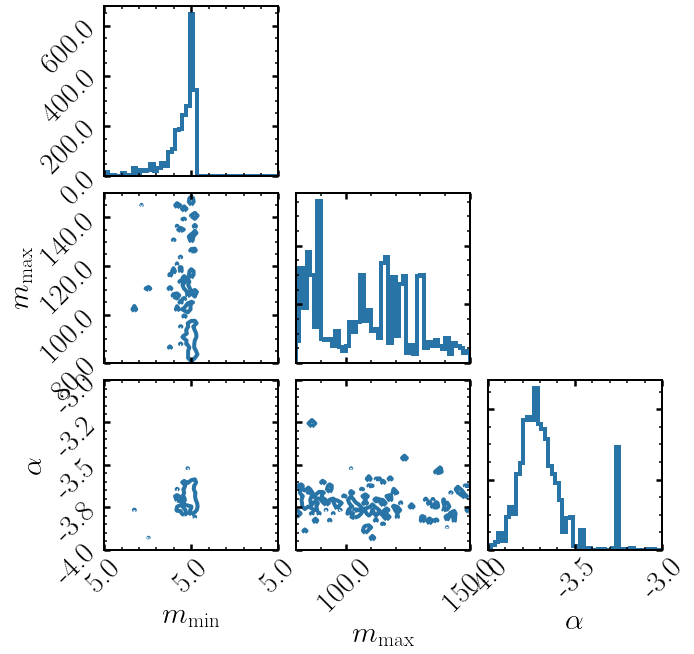

In [281]:
Ndim = 3
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(Ndim,Ndim,wspace=0.1,hspace=0.1)
Nbins = 50
axis = np.array([np.linspace(4.99,5.01,Nbins),np.linspace(mmax_low,mmax_hi,Nbins),np.linspace(-4.0, -3.0, Nbins)])
xlabel = [r'$m_{\rm min}$',r'$m_{\rm max}$',r'$\alpha$']

for i in range(Ndim):
    for j in range(i+1):      
        ax = fig.add_subplot(grid[i,j])

        
colors = ['#2874A6','#b11226']

fill_corner(fig,sampler.flatchain.T,Ndim,axis,colors[0],style=['-'],fill_contours=False,lw=4,levels=[0.6])
counter = 0
for i in range(Ndim):
    for j in range(i+1):      
        ax = fig.axes[counter]
        if i!=Ndim-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(xlabel[j],fontsize=30)
            ax.set_xticklabels(np.around(ax.get_xticks(),1),rotation=45,fontsize=30)
        if j!=0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(xlabel[i],fontsize=30)
            ax.set_yticklabels(np.around(ax.get_yticks(),1),rotation=45,fontsize=30)
        counter += 1
        ax.tick_params(axis="both",direction="in",which='major',width=2.5,length=6,right=True,top=True)
        ax.tick_params(axis="both",direction="in",which='minor',width=1.5,length=3,right=True,top=True)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

        
fig.axes[0].set_ylabel('')
plt.tight_layout()


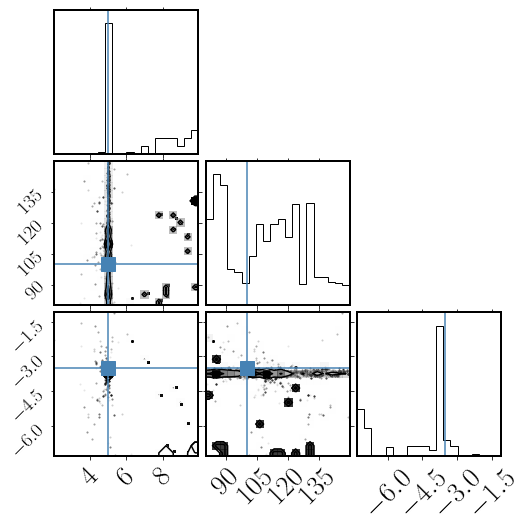

In [288]:
samples = sampler.flatchain

# samples
fig = corner.corner(samples, truths=[mmin_inj, mmax_inj, alpha_inj])


In [293]:
reader = emcee.backends.HDFBackend("ndim_3_nwalkers_30_nsteps_500.h5")
flatchain = reader.get_chain()

AttributeError: You must run the sampler with 'store == True' before accessing the results

# Scipy curve_fit test

In [83]:
mask = (m1_mu_detections<2000)

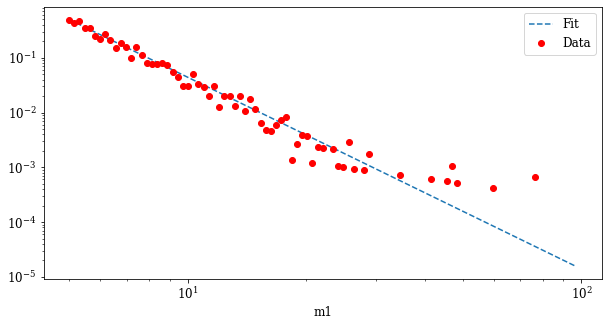

[-3.50185660e+00  5.00000000e+00  7.67578725e+03]


In [84]:
target_func = p_m1
bins = np.geomspace(5, 100, 100)

y, X = np.histogram(m1_mu_detections[mask], bins=bins, density=True)
X = X[:-1]
# plt.plot(X, y)
# plt.loglog()

popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-2.3, 5, 100])

plt.figure(figsize=(10, 5))
plt.plot(X, target_func(X, *popt), '--', label='Fit')
# plt.plot(X, p_m1(X,  -3.696, 5, 100), '--', label='Fit')

plt.plot(X, y, 'ro', label='Data')
plt.xlabel("m1")
plt.loglog()
plt.legend()

# plt.xlim(5, 30)

plt.show()


print(popt)